# **VinBigData Chest X-ray Abnormalities Detection**

# Exploratory Data Analysis + 2 class classifier pipeline using EfficientNet-B0

*In this competition, you’ll automatically localize and classify 14 types of thoracic abnormalities from chest radiographs. You'll work with a dataset consisting of 18,000 scans that have been annotated by experienced radiologists. You can train your model with 15,000 independently-labeled images and will be evaluated on a test set of 3,000 images. These annotations were collected via VinBigData's web-based platform, VinLab. Details on building the dataset can be found in our recent paper “[VinDr-CXR: An open dataset of chest X-rays with radiologist's annotations](https://arxiv.org/pdf/2012.15029.pdf)”.*

The EDA comes from different notebooks. You can refer to these to have more details:
* [https://www.kaggle.com/dschettler8845/visual-in-depth-eda-vinbigdata-competition-data](https://www.kaggle.com/dschettler8845/visual-in-depth-eda-vinbigdata-competition-data)
* [https://www.kaggle.com/bjoernholzhauer/eda-dicom-reading-vinbigdata-chest-x-ray](https://www.kaggle.com/bjoernholzhauer/eda-dicom-reading-vinbigdata-chest-x-ray)
* [https://www.kaggle.com/bryanb/vinbigdata-chest-x-ray-eda-fusing-boxes](https://www.kaggle.com/bryanb/vinbigdata-chest-x-ray-eda-fusing-boxes)

# IMPORTS  

In [41]:
# PIP Installs
!/opt/conda/bin/python3.7 -m pip install -q --upgrade pip      # Upgrade PIP
!pip install -q pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg # Install/Upgrade PyDicom Dependencies

# Machine Learning and Data Science Imports
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_hub as hub
from skimage import exposure
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
import sklearn

import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np
import scipy

# Built In Imports
from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2

# PRESETS
FIG_FONT = dict(family="Helvetica, Arial", size=14, color="#7f7f7f")
LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 15)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

# Other Imports
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm.notebook import tqdm
import pydicom
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
timm_path = "../input/timm-pytorch-image-models/pytorch-image-models-master"
import sys
sys.path.append(timm_path)
import timm

print("\n... IMPORTS COMPLETE ...\n")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


... IMPORTS COMPLETE ...



# EDA

## NOTEBOOK SETUP

In [42]:
# Define the root data directory
DATA_DIR = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection"

# Define the paths to the training and testing dicom folders respectively
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Capture all the relevant full train/test paths
TRAIN_DICOM_PATHS = [os.path.join(TRAIN_DIR, f_name) for f_name in os.listdir(TRAIN_DIR)]
TEST_DICOM_PATHS = [os.path.join(TEST_DIR, f_name) for f_name in os.listdir(TEST_DIR)]
print(f"\n... The number of training files is {len(TRAIN_DICOM_PATHS)} ...")
print(f"... The number of testing files is {len(TEST_DICOM_PATHS)} ...")

# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")

# Create the relevant dataframe objects
train_df = pd.read_csv(TRAIN_CSV)
ss_df = pd.read_csv(SS_CSV)

print("\n\nTRAIN DATAFRAME\n\n")
display(train_df.head(3))

print("\n\nSAMPLE SUBMISSION DATAFRAME\n\n")
display(ss_df.head(3))

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)



timm_path = "../input/timm-pytorch-image-models/pytorch-image-models-master"


... The number of training files is 15000 ...
... The number of testing files is 3000 ...


TRAIN DATAFRAME




image_id    class_name  class_id rad_id  x_min  \
0  50a418190bc3fb1ef1633bf9678929b3    No finding        14    R11    NaN   
1  21a10246a5ec7af151081d0cd6d65dc9    No finding        14     R7    NaN   
2  9a5094b2563a1ef3ff50dc5c7ff71345  Cardiomegaly         3    R10  691.0   

    y_min   x_max   y_max  
0     NaN     NaN     NaN  
1     NaN     NaN     NaN  
2  1375.0  1653.0  1831.0



SAMPLE SUBMISSION DATAFRAME




image_id PredictionString
0  002a34c58c5b758217ed1f584ccbcfe9     14 1 0 0 1 1
1  004f33259ee4aef671c2b95d54e4be68     14 1 0 0 1 1
2  008bdde2af2462e86fd373a445d0f4cd     14 1 0 0 1 1

In [43]:
test_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')
test_df.head()

image_id PredictionString
0  002a34c58c5b758217ed1f584ccbcfe9     14 1 0 0 1 1
1  004f33259ee4aef671c2b95d54e4be68     14 1 0 0 1 1
2  008bdde2af2462e86fd373a445d0f4cd     14 1 0 0 1 1
3  009bc039326338823ca3aa84381f17f1     14 1 0 0 1 1
4  00a2145de1886cb9eb88869c85d74080     14 1 0 0 1 1

In [44]:
train_df[['class_id', 'class_name', 'rad_id']].groupby(['class_id', 'class_name']).count().rename(columns={'rad_id': 'Number of records'})

Number of records
class_id class_name                           
0        Aortic enlargement               7162
1        Atelectasis                       279
2        Calcification                     960
3        Cardiomegaly                     5427
4        Consolidation                     556
5        ILD                              1000
6        Infiltration                     1247
7        Lung Opacity                     2483
8        Nodule/Mass                      2580
9        Other lesion                     2203
10       Pleural effusion                 2476
11       Pleural thickening               4842
12       Pneumothorax                      226
13       Pulmonary fibrosis               4655
14       No finding                      31818

So, what do these categories mean? This is actually explained in the paper linked on the competition homepage:

**Aortic enlargement:** "An abnormal bulge that occurs in the wall of the major blood vessel." 

**Atelectasis:** "Collapse of a part of the lung due to a decrease in the amount of air in the alveoli resulting in volume loss and increased density." (see also Merck Manual)

**Calcification:** "Deposition of calcium salts in the lung." - one article I looked at says that "[...] calcifications occur in a damaged lung following an inflammatory process such as infection (tuberculosis, histoplasmosis, Pneumocystis carnii), bleeding or pulmonary infarction" (Bendayan et al. 2000)

**Cardiomegaly:** "Enlargement of the heart, occurs when the heart of an adult patient is larger than normal and the cardiothoracic ratio is greater than 0.5."

**Consolidation:** "Any pathologic process that fills the alveoli with fluid, pus, blood, cells (including tumor cells) or other substances resulting in lobar, diffuse or multifocal ill-defined opacities."

**ILD:** "Interstitial lung disease (ILD) Involvement of the supporting tissue of the lung parenchyma resulting in fine or coarse reticular opacities or small nodules." (see also Merck Manual)

**Infiltration:** "An abnormal substance that accumulates gradually within cells or body tissues or any substance or type of cell that occurs within or spreads as through the interstices (interstitium and/or alveoli) of the lung, that is foreign to the lung, or that accumulates in greater than normal quantity within it."

**Lung Opacity:** "Any abnormal focal or generalized opacity or opacities in lung fields (blanket tag including but not limited to consolidation, cavity, fibrosis, nodule, mass, calcification, interstitial thickening, etc.)." 

**Nodule/Mass:** "Any space occupying lesion either solitary or multiple."

**Other lesion:** "Other lesions that are not on the list of findings or abnormalities mentioned above."

**Pleural effusion:** "Abnormal accumulations of fluid within the pleural space." (see also Merck Manual)

**Pleural thickening:** "Any form of thickening involving either the parietal or visceral pleura."

**Pneumothorax:** "The presence of gas (air) in the pleural space." (see also the Merck Manual)

**Pulmonary fibrosis:** "An excess of fibrotic tissue in the lung."

**No finding:** Kind of self-explanatory (there were no findings).

## ANNOTATIONS PER CLASS
 
We know there are 15 different possible class_names (including No finding). To identify the distribution of counts across the labels we will use a bar-chart.

In [45]:
fig = px.bar(train_df.class_name.value_counts().sort_index(), 
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS, log_y=True,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>",)
fig.update_layout(legend_title=None,
                  font=FIG_FONT,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

## RAD_ID COLUMN EXPLORATION
The rad_id column indicates the the ID of the radiologist that made the observation. Remember, three radiologists will annotate a given image out of a pool of seventeen possible radiologists, where the radiologist ID is encoded from R1 to R17.


#### ANNOTATIONS PER RADIOLOGIST

We know there are 17 possible radiologists (rad_ids). To identify the distribution of annotations performed across the radiologists we will use a historgram.

From the histogram plotted below we can ascertain the following information

3 of the radiologists (R9, R10, & R8 in that order) are responsible for the vast majority of annotations (~40-50% of all annotations)
Among the other 14 radiologists there is some variation around the number of annotations made, however, these 14 radiologists all made between 3121 annotations and 812 annotations with the vast majority annotating 1800-2200 objects.

In [46]:
fig = px.histogram(train_df, x="rad_id", color="rad_id",opacity=0.85,
                   labels={"rad_id":"Radiologist ID"},
                   title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER RADIOLOGIST</b>",
                   ).update_xaxes(categoryorder="total descending")
fig.update_layout(legend_title="<b>RADIOLOGIST ID</b>",
                  xaxis_title="<b>Radiologist ID</b>",
                  yaxis_title="<b>Number of Annotations Made</b>",
                  font=FIG_FONT,)
fig.show()

### ANNOTATIONS PER RADIOLOGIST SEPERATED BY CLASS LABEL

We have already identified that three of the radiologists are responsible for almost 50% of all of the annotations. We would now like to identify if all of the radiologists were able to see and annotate all 15 classes. If so, can we identify any additional skew or problems that might arise?

From the first histogram plotted below we can ascertain the following information

3 of the radiologists (R9, R10, & R8 in that order) are responsible for the vast majority of annotations (~40-50% of all annotations)
Among the other 11 radiologists there is some variation around the number of annotations made, however, these 11 radiologists all made between 3121 annotations and 812 annotations with the vast majority annotating 1800-2200 objects.
From the second histogram plotted below we can ascertain the following information

Among the other 11 radiologists, 7 of them (R1 through R7) have only ever annotated images as No finding
The other 4 radiologists are also heavily skewed towards the No finding label when compared to the main 3 radiologists (R8 through R10). This seems to actually be closer to the overall distribution, however it might allow us to estimate that radiologists other than R8, R9, and R10, are much more likely to annotate images as No finding.
The downside to this distribution, is that if we include this information in the model than the model will learn that 7 of the radiologists classify images as No finding 100% of the time!

In [47]:
# Create dictionary mappings
int_2_str = {i:train_df[train_df["class_id"]==i].iloc[0]["class_name"] for i in range(15)}
str_2_int = {v:k for k,v in int_2_str.items()}
int_2_clr = {str_2_int[k]:LABEL_COLORS[i] for i,k in enumerate(sorted(str_2_int.keys()))}

###### #
#  TO DO - NORMALIZE RADIOLOGIST COUNTS BASED ON ANNOTATION PER IMAGE  #
# #################################################################### #

fig = go.Figure()

for i in range(15):
    fig.add_trace(go.Histogram(
        x=train_df[train_df["class_id"]==i]["rad_id"],
        marker_color=int_2_clr[i],
        name=f"<b>{int_2_str[i]}</b>"))

fig.update_xaxes(categoryorder="total descending")
fig.update_layout(title="<b>DISTRIBUTION OF CLASS LABEL ANNOTATIONS BY RADIOLOGIST</b>",
                  barmode='stack',
                  xaxis_title="<b>Radiologist ID</b>",
                  yaxis_title="<b>Number of Annotations Made</b>",
                  font=FIG_FONT,)
fig.show()

fig = go.Figure()
for i in range(15):
    fig.add_trace(go.Histogram(
        x=train_df[(train_df["class_id"]==i) & (~train_df["rad_id"].isin(["R8","R9","R10"]))]["rad_id"],
        marker_color=int_2_clr[i],
        name=f"<b>{int_2_str[i]}</b>"))

fig.update_xaxes(categoryorder="total descending")
fig.update_layout(title="<b>DISTRIBUTION OF CLASS LABEL ANNOTATIONS BY RADIOLOGIST   " \
                  "<i><sub>(EXCLUDING TOP 3 RADIOLOGISTS --> R8, R9 & R10)</sub></i></b>",
                  barmode='stack',
                  xaxis_title="<b>Radiologist ID</b>",
                  yaxis_title="<b>Number of Annotations Made</b>",
                  font=FIG_FONT,)
fig.show()

## CORRELATION BETWEEN CLASSES

How is the occurence of the different classes correlated? Unsurprisingly, no finding is negatively correlated with all findings, while the various findings are slightly positively correlated, except for a few exceptions with strong correlations such as '0: Aortic enlargement' and '3: Cardiomegaly'.

In [48]:
tmpdf = train_df[['class_id', 'image_id', 'rad_id']].groupby(['class_id', 'image_id']).count().reset_index()
tmpdf['rad_id'] = np.minimum(tmpdf['rad_id'].values, 1)
corr  = tmpdf.pivot(index='image_id', columns='class_id', values='rad_id').fillna(0).reset_index(drop=True).corr()
corr.style.background_gradient(cmap='coolwarm', vmin=-1.0, vmax=1.0).set_precision(2)

Where do the different findings tend to be?
As we can see below, certain findings tend to concentrate in certain area - we'll ignore that images might not all be the same size. E.g. aortic enlargment is where the aorta is, cardiomegaly is around the heart, etc., which may be useful for checking the plausibility of model outputs/knowledge we might try to explicitly provide to networks (that of course assumes that all images show upper bodies from a similar distance).

In [49]:
locations = np.zeros((14, int(np.ceil(np.max(train_df.y_max)/10)*10), int(np.ceil(np.max(train_df.x_max)/10)*10)))
for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    if row['class_id']<14:
        locations[row['class_id'], int(row['y_min']):int(row['y_max']+1), int(row['x_min']):int(row['x_max']+1)] += 1

  0%|          | 0/67914 [00:00<?, ?it/s]

In [50]:
classes = train_df[['class_id', 'class_name', 'rad_id']].groupby(['class_id', 'class_name']).count().rename(columns={'rad_id': 'Number of records'}).reset_index()

for index, row in classes.iterrows():
    if index==0:
        label_dict = {row['class_id']: row['class_name']}
    else:
        label_dict.update({row['class_id']: row['class_name']})

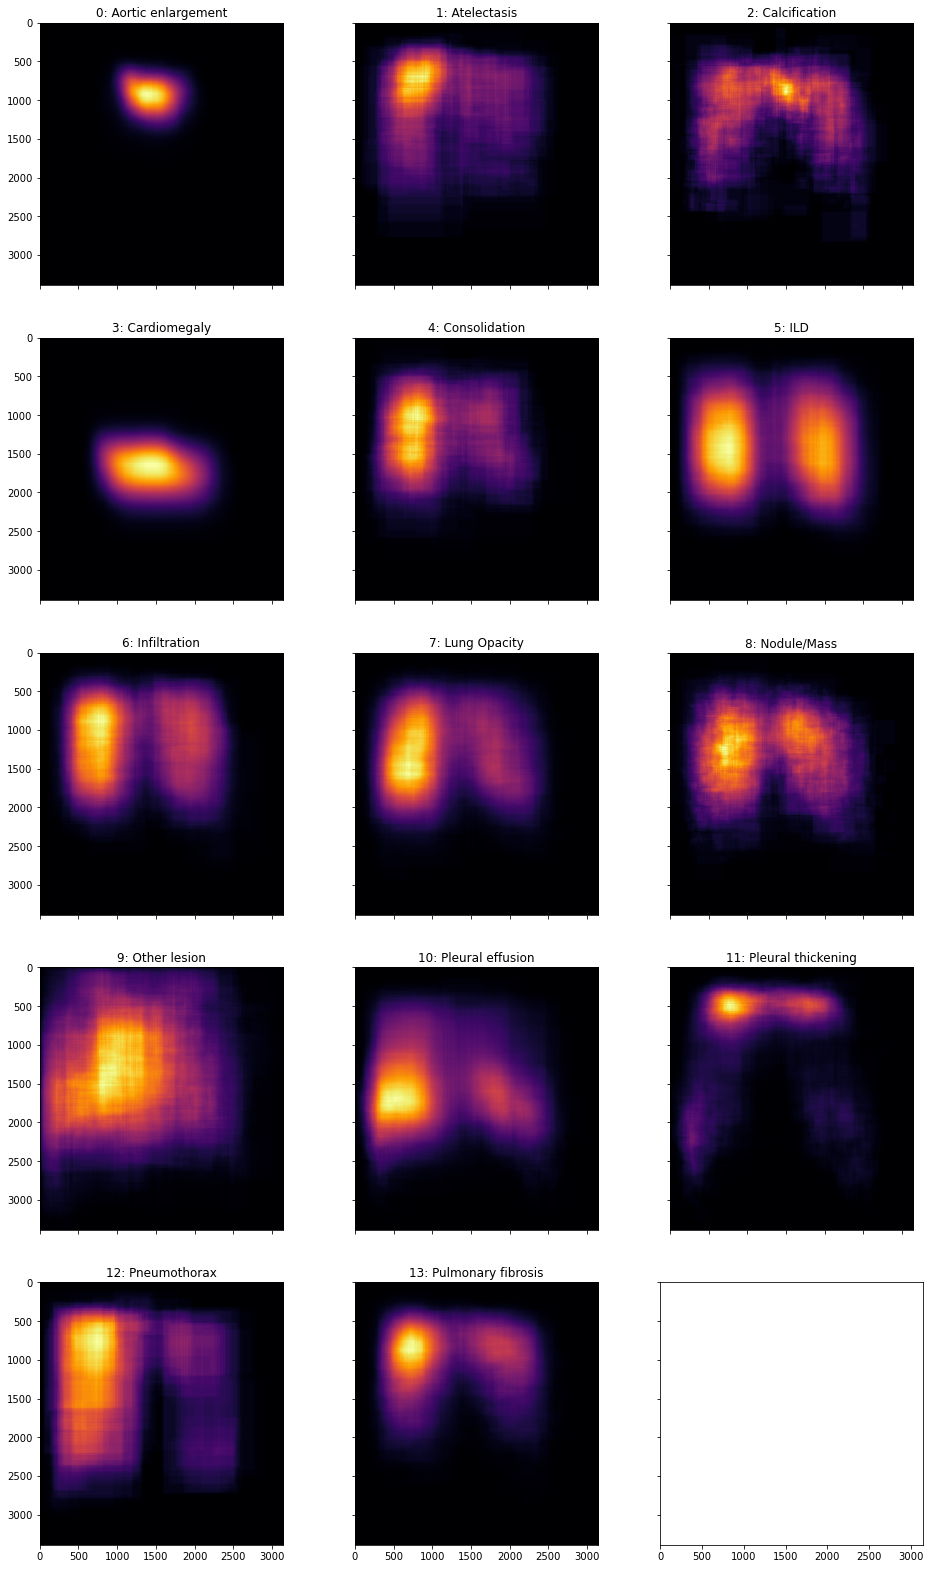

In [51]:
f, axs = plt.subplots(5, 3, sharey=True, sharex=True, figsize=(16,28));

for class_id in range(14):
    axs[class_id // 3, class_id - 3*(class_id // 3)].imshow(locations[class_id], cmap='inferno', interpolation='nearest');
    axs[class_id // 3, class_id - 3*(class_id // 3)].set_title(str(class_id) + ': ' + label_dict[class_id])
    
plt.show();

## INVESTIGATE THE ASPECT RATIO OF BOUNDING BOXES AND THE IMPACT OF CLASS

We want to understand the average shape (wide-narrow, square, etc.) of the bouning-boxes associated with each class, and to do this we will use a bar chart with some pre-drawn lines.

From the bar chart plotted below we can ascertain the following information: 

The average size of bounding-boxes by class is usually close to square (usually on the horizontal rectangle size of square). \
**Cardiomegaly** has, on average, very thin, rectangular, horizontal boxes (mean width is ~2.9x larger than mean height). \
**Pleural Thickening** has, on average, thin, rectangular, horizontal boxes (mean width is ~1.9x larger than mean height). \
**ILD** has, on average, somewhat thin, rectangular, vertical boxes (mean height is ~1.6x larger than mean width)

In [52]:
# Get paths to images where bboxes exist `class_id!=14`
bbox_df = train_df[train_df.class_id!=14].reset_index(drop=True)

# Aspect Ratio is Calculated as Width/Height
bbox_df["aspect_ratio"] = (bbox_df["x_max"]-bbox_df["x_min"])/(bbox_df["y_max"]-bbox_df["y_min"])

# Display average means for each class_id so we can examine the newly created Aspect Ratio Column
display(bbox_df.groupby("class_id").mean())

# Generate the bar plot
fig = px.bar(x=[int_2_str[x] for x in range(14)], y=bbox_df.groupby("class_id").mean()["aspect_ratio"], 
             color=[int_2_str[x] for x in range(14)], opacity=0.85,
             color_discrete_sequence=LABEL_COLORS_WOUT_NO_FINDING, 
             labels={"x":"Class Name", "y":"Aspect Ratio (W/H)"},
             title="<b>Aspect Ratios For Bounding Boxes By Class</b>",)
fig.update_layout(font=FIG_FONT,
                  yaxis_title="<b>Aspect Ratio (W/H)</b>",
                  xaxis_title=None,
                  legend_title_text=None)
fig.add_hline(y=1, line_width=2, line_dash="dot", 
              annotation_font_size=10, 
              annotation_text="<b>SQUARE ASPECT RATIO</b>", 
              annotation_position="bottom left", 
              annotation_font_color="black")
fig.add_hrect(y0=0, y1=0.5, line_width=0, fillcolor="red", opacity=0.125,
              annotation_text="<b>>2:1 VERTICAL RECTANGLE REGION</b>", 
              annotation_position="bottom right", 
              annotation_font_size=10,
              annotation_font_color="red")
fig.add_hrect(y0=2, y1=3.5, line_width=0, fillcolor="green", opacity=0.04,
              annotation_text="<b>>2:1 HORIZONTAL RECTANGLE REGION</b>", 
              annotation_position="top right", 
              annotation_font_size=10,
              annotation_font_color="green")
fig.show()

x_min        y_min        x_max        y_max  aspect_ratio
class_id                                                                  
0         1262.947640   757.448338  1571.274225  1099.532812      0.919162
1          903.379928   726.734767  1438.347670  1362.731183      1.094238
2         1219.472917  1028.112500  1432.578125  1303.685417      0.936076
3          890.269394  1480.981021  1961.129722  1875.411093      2.878940
4          879.832734   967.582734  1360.510791  1552.404676      0.948068
5         1015.389000   889.004000  1588.900000  1925.599000      0.637270
6          984.099439   870.377706  1455.623897  1492.323978      0.897174
7          948.639952  1037.773661  1356.880387  1529.251309      1.018965
8         1153.891473  1204.681395  1324.701163  1404.732946      0.992708
9          980.679074  1035.812982  1348.041761  1571.484793      1.020983
10         929.954362  1651.670032  1296.953958  2140.476171      0.877636
11        1043.314333   998.408715  1305.072284  1196.494011      1.917301
12         745.845133   702.393805  1412.331858  1743.035398      0.933639
13        1053.038024   910.450054  1380.268958  1262.086144      1.294535

## PLOT IMAGES FROM THE CORRESPONDING IMAGE IDS

In [53]:
# Create dictionary mappings
int_2_str = {i:train_df[train_df["class_id"]==i].iloc[0]["class_name"] for i in range(15)}
str_2_int = {v:k for k,v in int_2_str.items()}
int_2_clr = {str_2_int[k]:LABEL_COLORS[i] for i,k in enumerate(sorted(str_2_int.keys()))}
train_df.drop(columns=["class_name"], inplace=True)

In [54]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    """ Convert dicom file to numpy array 
    
    Args:
        path (str): Path to the dicom file to be converted
        voi_lut (bool): Whether or not VOI LUT is available
        fix_monochrome (bool): Whether or not to apply monochrome fix
        
    Returns:
        Numpy array of the respective dicom file 
        
    """
    # Use the pydicom library to read the dicom file
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to 
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    # The XRAY may look inverted
    #   - If we want to fix this we can
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    # Normalize the image array and return
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def plot_image(img, title="", figsize=(8,8), cmap=None):
    """ Function to plot an image to save a bit of time """
    plt.figure(figsize=figsize)
    
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        img
        plt.imshow(img)
        
    plt.title(title, fontweight="bold")
    plt.axis(False)
    plt.show()
    
def get_image_id(path):
    """ Function to return the image-id from a path """
    return path.rsplit("/", 1)[1].rsplit(".", 1)[0]

def create_fractional_bbox_coordinates(row):
    """ Function to return bbox coordiantes as fractions from DF row """
    frac_x_min = row["x_min"]/row["img_width"]
    frac_x_max = row["x_max"]/row["img_width"]
    frac_y_min = row["y_min"]/row["img_height"]
    frac_y_max = row["y_max"]/row["img_height"]
    return frac_x_min, frac_x_max, frac_y_min, frac_y_max

def draw_bboxes(img, tl, br, rgb, label="", label_location="tl", opacity=0.1, line_thickness=0):
    """ TBD 
    
    Args:
        TBD
        
    Returns:
        TBD 
    """
    rect = np.uint8(np.ones((br[1]-tl[1], br[0]-tl[0], 3))*rgb)
    sub_combo = cv2.addWeighted(img[tl[1]:br[1],tl[0]:br[0],:], 1-opacity, rect, opacity, 1.0)    
    img[tl[1]:br[1],tl[0]:br[0],:] = sub_combo

    if line_thickness>0:
        img = cv2.rectangle(img, tuple(tl), tuple(br), rgb, line_thickness)
        
    if label:
        # DEFAULTS
        FONT = cv2.FONT_HERSHEY_SIMPLEX
        FONT_SCALE = 1.666
        FONT_THICKNESS = 3
        FONT_LINE_TYPE = cv2.LINE_AA
        
        if type(label)==str:
            LABEL = label.upper().replace(" ", "_")
        else:
            LABEL = f"CLASS_{label:02}"
        
        text_width, text_height = cv2.getTextSize(LABEL, FONT, FONT_SCALE, FONT_THICKNESS)[0]
        
        label_origin = {"tl":tl, "br":br, "tr":(br[0],tl[1]), "bl":(tl[0],br[1])}[label_location]
        label_offset = {
            "tl":np.array([0, -10]), "br":np.array([-text_width, text_height+10]), 
            "tr":np.array([-text_width, -10]), "bl":np.array([0, text_height+10])
        }[label_location]
        img = cv2.putText(img, LABEL, tuple(label_origin+label_offset), 
                          FONT, FONT_SCALE, rgb, FONT_THICKNESS, FONT_LINE_TYPE)
    
    return img

In [55]:
class TrainData():
    def __init__(self, df, train_dir, cmap="Spectral"):
        # Initialize
        self.df = df
        self.train_dir = train_dir
        
        # Visualization
        self.cmap = cmap
        self.pal = [tuple([int(x) for x in np.array(c)*(255,255,255)]) for c in sns.color_palette(cmap, 15)]
        self.pal.pop(8)
        
        # Store df components in individual numpy arrays for easy access based on index
        tmp_numpy = self.df.to_numpy()
        image_ids = tmp_numpy[0]
        class_ids = tmp_numpy[1]
        rad_ids = tmp_numpy[2]
        bboxes = tmp_numpy[3:]
        
        self.img_annotations = self.get_annotations(get_all=True)
        
        # Clean-Up
        del tmp_numpy; gc.collect();
        
        
    def get_annotations(self, get_all=False, image_ids=None, class_ids=None, rad_ids=None, index=None):
        """ TBD 
        
        Args:
            get_all (bool, optional): TBD
            image_ids (list of strs, optional): TBD
            class_ids (list of ints, optional): TBD
            rad_ids (list of strs, optional): TBD
            index (int, optional):
        
        Returns:
        
        
        """
        if not get_all and image_ids is None and class_ids is None and rad_ids is None and index is None:
            raise ValueError("Expected one of the following arguments to be passed:" \
                             "\n\t\t– `get_all`, `image_id`, `class_id`, `rad_id`, or `index`")
        # Initialize
        tmp_df = self.df.copy()
        
        if not get_all:
            if image_ids is not None:
                tmp_df = tmp_df[tmp_df.image_id.isin(image_ids)]
            if class_ids is not None:
                tmp_df = tmp_df[tmp_df.class_id.isin(class_ids)]
            if rad_ids is not None:
                tmp_df = tmp_df[tmp_df.rad_id.isin(rad_ids)]
            if index is not None:
                tmp_df = tmp_df.iloc[index]
            
        annotations = {image_id:[] for image_id in tmp_df.image_id.to_list()}
        for row in tmp_df.to_numpy():
            
            # Update annotations dictionary
            annotations[row[0]].append(dict(
                img_path=os.path.join(self.train_dir, row[0]+".dicom"),
                image_id=row[0],
                class_id=int(row[1]),
                rad_id=int(row[2][1:]),
            ))
            
            # Catch to convert float array to integer array
            if row[1]==14:
                annotations[row[0]][-1]["bbox"]=row[3:]
            else:
                annotations[row[0]][-1]["bbox"]=row[3:].astype(np.int32)
        return annotations
    
    def get_annotated_image(self, image_id, annots=None, plot=False, plot_size=(18,25), plot_title=""):
        if annots is None:
            annots = self.img_annotations.copy()
        
        if type(annots) != list:
            image_annots = annots[image_id]
        else:
            image_annots = annots
            
        img = cv2.cvtColor(dicom2array(image_annots[0]["img_path"]),cv2.COLOR_GRAY2RGB)
        for ann in image_annots:
            if ann["class_id"] != 14:
                img = draw_bboxes(img, 
                                ann["bbox"][:2], ann["bbox"][-2:], 
                                rgb=self.pal[ann["class_id"]], 
                                label=int_2_str[ann["class_id"]], 
                                opacity=0.08, line_thickness=4)
        if plot:
            plot_image(img, title=plot_title, figsize=plot_size)
        
        return img
    
    def plot_image_ids(self, image_id_list, height_multiplier=6, verbose=True):
        annotations = self.get_annotations(image_ids=image_id_list)
        annotated_imgs = []
        n = len(image_id_list)
        
        plt.figure(figsize=(20, height_multiplier*n))
        for i, (image_id, annots) in enumerate(annotations.items()):
            if i >= n:
                break
            if verbose:
                print(f".", end="")
            plt.subplot(n//2,2,i+1)
            plt.imshow(self.get_annotated_image(image_id, annots))
            plt.axis(False)
            plt.title(f"Image ID – {image_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
        
    def plot_classes(self, class_list, n=4, height_multiplier=6, verbose=True):
        annotations = self.get_annotations(class_ids=class_list)
        annotated_imgs = []

        plt.figure(figsize=(20, height_multiplier*n))
        for i, (image_id, annots) in enumerate(annotations.items()):
            if i >= n:
                break
            if verbose:
                print(f".", end="")
            plt.subplot(n//2,2,i+1)
            plt.imshow(self.get_annotated_image(image_id, annots))
            plt.axis(False)
            plt.title(f"Image ID – {image_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

    def plot_radiologists(self, rad_id_list, n=4, height_multiplier=6, verbose=True):
        annotations = self.get_annotations(rad_ids=rad_id_list)
        annotated_imgs = []

        plt.figure(figsize=(20, height_multiplier*n))
        for i, (image_id, annots) in enumerate(annotations.items()):
            if i >= n:
                break
            if verbose:
                print(f".", end="")
            plt.subplot(n//2,2,i+1)
            plt.imshow(self.get_annotated_image(image_id, annots))
            plt.axis(False)
            plt.title(f"Image ID – {image_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

train_data = TrainData(train_df, TRAIN_DIR)

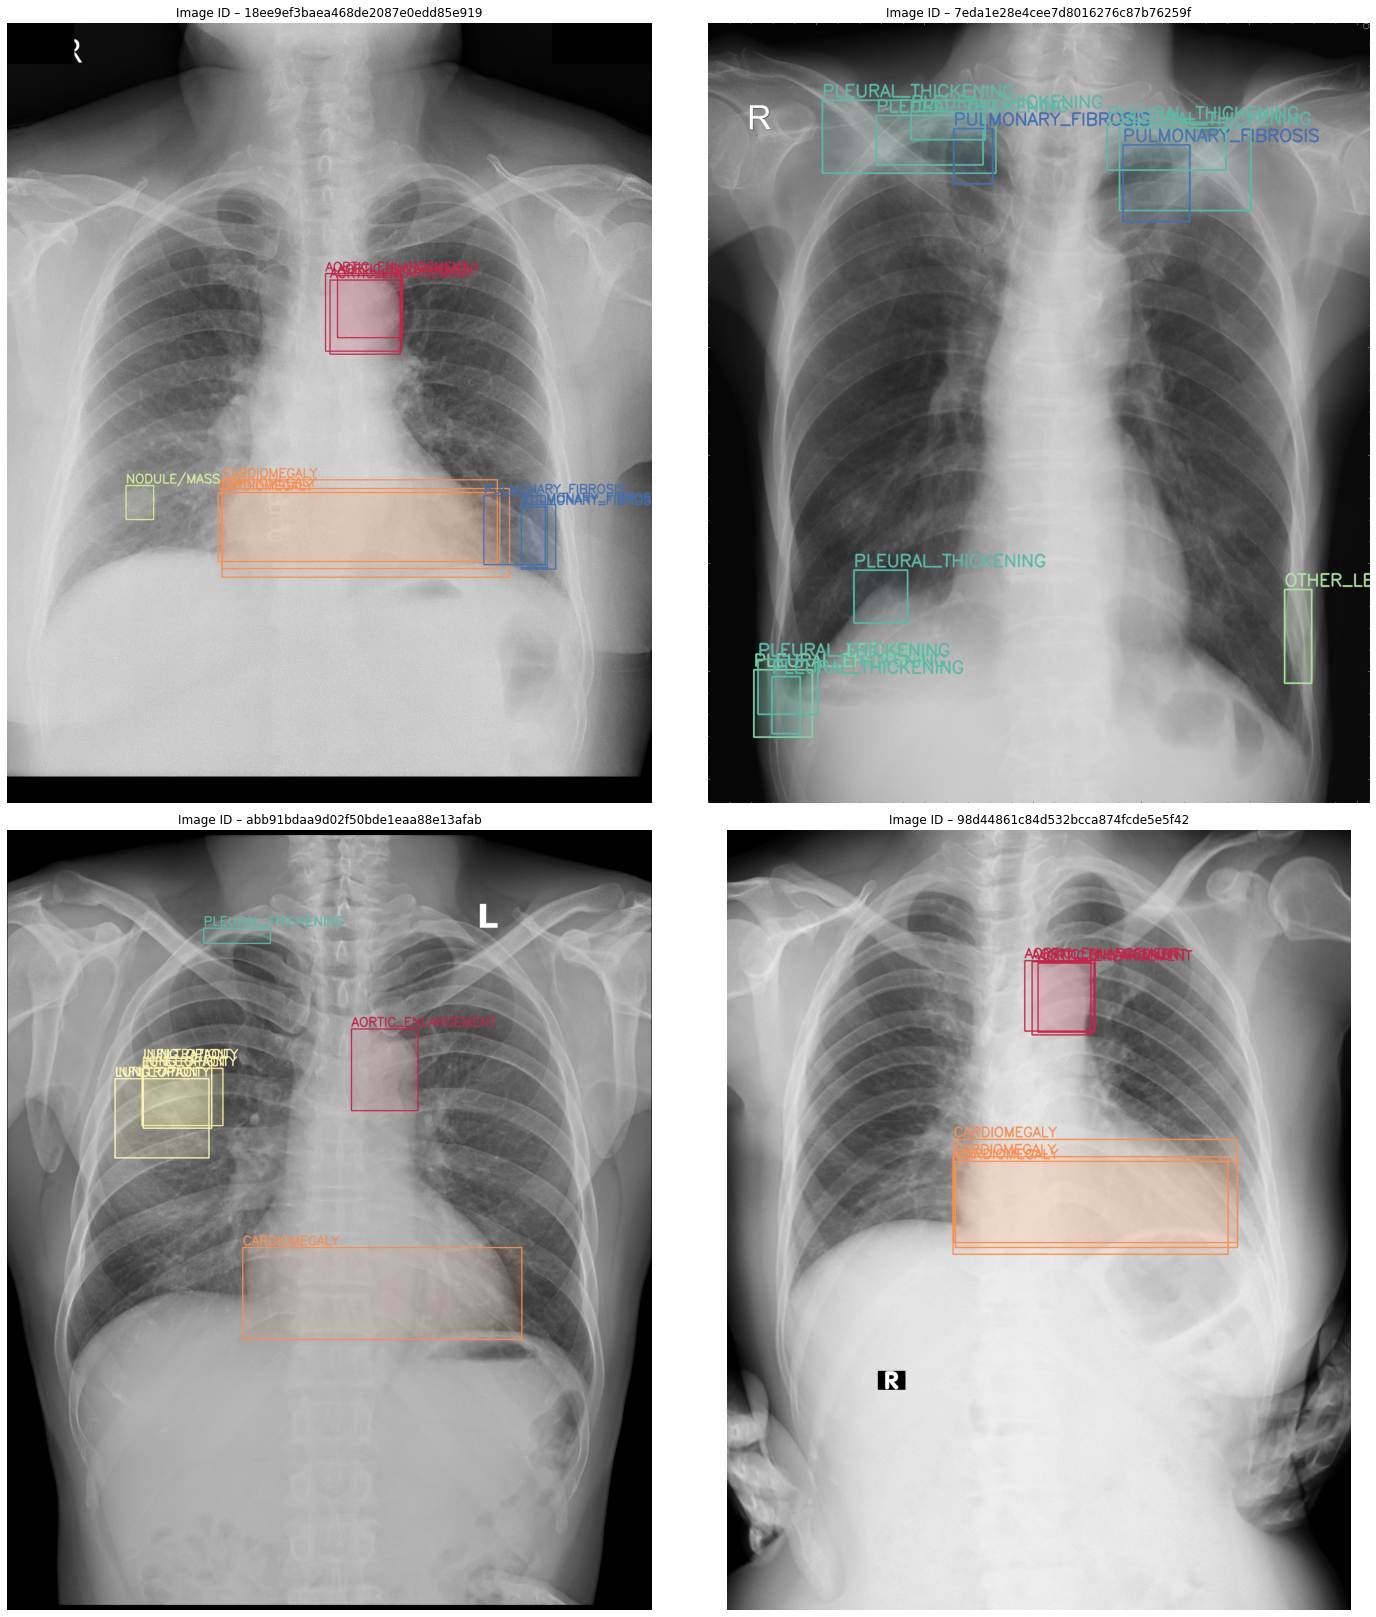

In [56]:
IMAGE_ID_LIST = train_df[train_df.class_id!=14].image_id[25:29].to_list()
train_data.plot_image_ids(image_id_list=IMAGE_ID_LIST, verbose=False)

## EDA WITH METADATA

Let's consider we extracted all metadata, you can find the data here: https://www.kaggle.com/bryanb/vinbigdata-chestxray-metadata

I chose to keep only few information: sex, age, height and weight

In [57]:
# Load full metadata set
train_metadata = pd.read_csv("../input/vinbigdata-chestxray-metadata/train_dicom_metadata.csv")
test_metadata = pd.read_csv("../input/vinbigdata-chestxray-metadata/test_dicom_metadata.csv")

In [58]:
# Keep some columns only
train_metadata_filtered = train_metadata[["Patient's Sex", "Patient's Age", "Patient's Size", "Patient's Weight"]]
test_metadata_filtered = test_metadata[["Patient's Sex", "Patient's Age", "Patient's Size", "Patient's Weight"]]

In [59]:
print(train_metadata_filtered["Patient's Size"].value_counts())
print(train_metadata_filtered["Patient's Weight"].value_counts())

print(test_metadata_filtered["Patient's Size"].value_counts())
print(test_metadata_filtered["Patient's Weight"].value_counts())

train_metadata_filtered = train_metadata_filtered.drop(["Patient's Size", "Patient's Weight"], axis=1)
test_metadata_filtered = test_metadata_filtered.drop(["Patient's Size", "Patient's Weight"], axis=1)

0.0     1434
None     703
Name: Patient's Size, dtype: int64
0.0     1434
None     703
Name: Patient's Weight, dtype: int64
0.0     308
None    129
Name: Patient's Size, dtype: int64
0.0     308
None    129
Name: Patient's Weight, dtype: int64


In [60]:
def get_first_el(row):
    resu = 'NA'
    if len(str(row))>5:
        resu = re.search(r"(?<=\[)(.*?)(?=\,)", row).group()
    return resu

In [61]:
train_metadata_filtered["Patient's Sex"] = train_metadata_filtered["Patient's Sex"].fillna("NA")
train_metadata_filtered.loc[train_metadata_filtered["Patient's Sex"]=="O"] = np.nan

train_metadata_filtered["Patient's Age"] = train_metadata_filtered["Patient's Age"].fillna("0")
train_metadata_filtered["Patient's Age"] = train_metadata_filtered["Patient's Age"].apply(lambda x:re.search(r"\d*", str(x)).group())
train_metadata_filtered.loc[train_metadata_filtered["Patient's Age"]== '']= np.nan
train_metadata_filtered["Patient's Age"] = train_metadata_filtered["Patient's Age"].astype(float)
test_metadata_filtered["Patient's Sex"] = test_metadata_filtered["Patient's Sex"].fillna("NA")
test_metadata_filtered.loc[test_metadata_filtered["Patient's Sex"]=="O"] = np.nan

test_metadata_filtered["Patient's Age"] = test_metadata_filtered["Patient's Age"].fillna("0")
test_metadata_filtered["Patient's Age"] = test_metadata_filtered["Patient's Age"].apply(lambda x:re.search(r"\d*", str(x)).group())
test_metadata_filtered.loc[test_metadata_filtered["Patient's Age"]== '']= np.nan
test_metadata_filtered["Patient's Age"] = test_metadata_filtered["Patient's Age"].astype(float)


In [62]:
train_metadata_filtered.to_csv("train_dicom_metadata_filtered.csv", index=False)
test_metadata_filtered.to_csv("test_dicom_metadata_filtered.csv", index=False)

In [63]:
train_metadata_age = train_metadata_filtered.loc[(train_metadata_filtered["Patient's Age"] > 0) & 
                                                 (train_metadata_filtered["Patient's Age"] < 100), :]

fig = px.histogram(train_metadata_age, x="Patient's Age",
                   marginal="box",
                   hover_data=train_metadata_age.columns)

fig.update_layout(
    title="Age distribution (train)")

fig.show()

del(train_metadata_age)

In [64]:
train_metadata_counts = list(train_metadata_filtered.loc[train_metadata_filtered["Patient's Sex"] != "NA", "Patient's Sex"].value_counts())
train_metadata_labels = list(train_metadata_filtered.loc[train_metadata_filtered["Patient's Sex"] != "NA", "Patient's Sex"].value_counts().index)

fig = go.Figure(data=[go.Pie(labels=train_metadata_labels, 
                             values=train_metadata_counts, 
                             hole=.3,
                             title_text="Sex distribution (train)")])
fig.show()

del(train_metadata_counts, train_metadata_labels)

In [65]:
data = train_metadata_filtered.loc[(train_metadata_filtered["Patient's Sex"] != "NA") &
                                   (train_metadata_filtered["Patient's Age"] > 0) &
                                   (train_metadata_filtered["Patient's Age"] < 100), :]

fig = px.histogram(data, 
                   x="Patient's Age", 
                   color="Patient's Sex", 
                   marginal="box",
                   hover_data=data.columns,
                   histnorm = "probability")

fig.update_layout(
    title="Age distribution by sex (train)")

fig.show()

del(data)

# 2 CLASS CLASSIFIER PIPELINE USING EFFICIENTNET

To have a better understanding of the following code, you can refer to the following notebook: 
* [https://www.kaggle.com/mrinath/2-class-classifier-pipeline-using-effnet](https://www.kaggle.com/mrinath/2-class-classifier-pipeline-using-effnet)

I decided to use the same method than the notebook linked above but tried with a different model.

In [66]:
#train  =  pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv") 
is_normal_df = train_df.groupby("image_id")["class_id"].agg(lambda s: (s == 14).sum()).reset_index().rename({"class_id": "num_normal_annotations"}, axis=1)
is_normal_df.head()

image_id  num_normal_annotations
0  000434271f63a053c4128a0ba6352c7f                       3
1  00053190460d56c53cc3e57321387478                       3
2  0005e8e3701dfb1dd93d53e2ff537b6e                       0
3  0006e0a85696f6bb578e84fafa9a5607                       3
4  0007d316f756b3fa0baea2ff514ce945                       0

In [67]:
def change(x):
    if (x==3):
        x=1
    return x
is_normal_df['target'] = is_normal_df['num_normal_annotations'].apply(lambda x: change(x))
df = is_normal_df[["image_id","target"]]
df.head()

image_id  target
0  000434271f63a053c4128a0ba6352c7f       1
1  00053190460d56c53cc3e57321387478       1
2  0005e8e3701dfb1dd93d53e2ff537b6e       0
3  0006e0a85696f6bb578e84fafa9a5607       1
4  0007d316f756b3fa0baea2ff514ce945       0

## SPLITTING

In [68]:
from sklearn.model_selection import StratifiedKFold
skf  =  StratifiedKFold(n_splits = 5, random_state = 42,shuffle = True)
folds = df.copy()
for f,(tr_idx,val_idx) in enumerate(skf.split(folds,folds.target)):
    folds.loc[val_idx,'fold'] = int(f)
folds['fold'] = folds['fold'].astype(int)    


In [69]:
folds.image_id=folds.image_id+".png"
img_path = "../input/vinbigdata-chest-xray-resized-png-1024x1024/train"
df_paths = [os.path.join(img_path,x) for x in folds.image_id]
folds['path'] = df_paths
folds.head()

image_id  target  fold  \
0  000434271f63a053c4128a0ba6352c7f.png       1     0   
1  00053190460d56c53cc3e57321387478.png       1     3   
2  0005e8e3701dfb1dd93d53e2ff537b6e.png       0     0   
3  0006e0a85696f6bb578e84fafa9a5607.png       1     3   
4  0007d316f756b3fa0baea2ff514ce945.png       0     1   

                                                path  
0  ../input/vinbigdata-chest-xray-resized-png-102...  
1  ../input/vinbigdata-chest-xray-resized-png-102...  
2  ../input/vinbigdata-chest-xray-resized-png-102...  
3  ../input/vinbigdata-chest-xray-resized-png-102...  
4  ../input/vinbigdata-chest-xray-resized-png-102...

## TRANSFORMS

In [70]:
train_aug = A.Compose(
    [  

        A.Resize(300,300,p=1.0),
        A.CLAHE(clip_limit=4.0, p=0.85),

     A.Normalize(
            p=1.0),
        ToTensorV2(p=1.0)
    ]
)
val_aug = A.Compose(
    [
         A.Resize(300,300,p=1.0),
        A.HorizontalFlip(p=0.5),
         A.Normalize(
            p=1.0),
        ToTensorV2(p=1.0),
    ]
)

In [71]:
class Xray(Dataset):
    def __init__(self,df,augs=None):
        self.df = df
        self.augs = augs
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        img_src = self.df.loc[idx,'path']
        image = cv2.imread(img_src)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        
        target = self.df.loc[idx,'target']
        
        if (self.augs):
            transformed = self.augs(image=image)
            image = transformed['image']
        
        return image,torch.tensor(target) 

In [72]:
data = Xray(folds,augs = train_aug)
load = DataLoader(data,batch_size = 1)
img,target = next(iter(load))

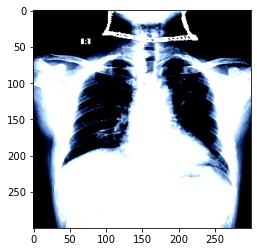

In [73]:
plt.imshow(img.squeeze(0).permute(1,2,0))

## EFFICIENTNET-B0 MODEL

In [74]:
model=timm.create_model('efficientnet_b0', pretrained=False) # set pretrained=True to use the pretrained weights
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 1)
for param in model.parameters():
    param.requires_grad_(True)
    
#for param in model.parameters():
#    param.requires_grad_(False)
#ct = 0
#for child in model.children():
#    ct += 1
#    if ct > 8:
#        for param in child.parameters():
#            param.requires_grad = True
#model

In [75]:
ss=F.sigmoid(model(torch.randn(3,3,300,300)))
ss

tensor([[0.5304],
        [0.5213],
        [0.5187]], grad_fn=<SigmoidBackward>)

## HELPING FUNCTIONS

In [76]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [77]:
def train_one_epoch(train_loader,model,optimizer,criterion,e,epochs):
    losses = AverageMeter()
    scores = AverageMeter()
    model.train()
    global_step = 0
    loop = tqdm(enumerate(train_loader),total = len(train_loader))
    
    for step,(image,labels) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels= labels.to(device)
        output = model(image)
        batch_size = labels.size(0)
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = sklearn.metrics.roc_auc_score(targets, outputs)
            losses.update(loss.item(), batch_size)
            scores.update(auc.item(), batch_size)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        
            loop.set_description(f"Epoch {e+1}/{epochs}")
            loop.set_postfix(loss = loss.item(), auc = auc.item(), stage = 'train')
        
            
        except ValueError:
            pass
        
        
       
        
    return losses.avg,scores.avg

In [78]:
def val_one_epoch(loader,model,optimizer,criterion):
    losses = AverageMeter()
    scores = AverageMeter()
    model.eval()
    global_step = 0
    loop = tqdm(enumerate(loader),total = len(loader))
    
    for step,(image,labels) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            output = model(image)
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = sklearn.metrics.roc_auc_score(targets, outputs)
            losses.update(loss.item(), batch_size)
            scores.update(auc.item(), batch_size)
            loop.set_postfix(loss = loss.item(), auc = auc.item(), stage = 'valid')
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        except ValueError:
            pass
        
        
        
        
        
    
        
    return losses.avg,scores.avg

## TRAINING LOOP

In [79]:
def fit(model,fold_n,training_batch_size=32,validation_batch_size=64):
    
    train_data=folds[folds.fold != fold_n]
    val_data=folds[folds.fold == fold_n]
    train_data= Xray(train_data.reset_index(drop=True),augs = train_aug)
    val_data= Xray(val_data.reset_index(drop=True),augs = val_aug)
    
    
    train_loader = DataLoader(train_data,
                             shuffle=True,
                        num_workers=0,
                        batch_size=training_batch_size)
    valid_loader = DataLoader(val_data,
                             shuffle=False,
                        num_workers=0,
                        batch_size=validation_batch_size)
    model = model
    model.to(device)
    criterion=nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 3,verbose = True)
    epochs= 5
    
    best_acc = 0
    
    loop = range(epochs)
    for e in loop:
        
        train_loss,train_auc = train_one_epoch(train_loader,model,optimizer,criterion,e,epochs)
         #scheduling step if given
    
        #scheduler.step()
        
        print(f'For epoch {e+1}/{epochs}')
        print(f'average train_loss {train_loss}')
        print(f'average train_auc {train_auc}' )
        
        val_loss,val_auc = val_one_epoch(valid_loader,model,optimizer,criterion)
        
        scheduler.step(val_loss)
        
        print(f'avarage val_loss { val_loss }')
        print(f'avarage val_auc {val_auc}')
        
        
        
        
        if (val_auc>best_acc):
            best_acc =val_auc
            print(f'saving model for {best_acc}')
            torch.save(model.state_dict(),OUTPUT_DIR+ f'Fold {fold_n} model with val_acc {best_acc}.pth')

In [80]:
fit(model,0)

  0%|          | 0/375 [00:00<?, ?it/s]

For epoch 1/5
average train_loss 0.4406624043782552
average train_auc 0.8251863843176961


  0%|          | 0/47 [00:00<?, ?it/s]

avarage val_loss 0.6332807278633118
avarage val_auc 0.7373149324217875
saving model for 0.7373149324217875


  0%|          | 0/375 [00:00<?, ?it/s]

For epoch 2/5
average train_loss 0.2706001852154732
average train_auc 0.9520475121411943


  0%|          | 0/47 [00:00<?, ?it/s]

avarage val_loss 0.5074757364590963
avarage val_auc 0.8451786231602687
saving model for 0.8451786231602687


  0%|          | 0/375 [00:00<?, ?it/s]

For epoch 3/5
average train_loss 0.22122636792063713
average train_auc 0.9679046383472749


  0%|          | 0/47 [00:00<?, ?it/s]

avarage val_loss 0.37926737912495934
avarage val_auc 0.9244822438123235
saving model for 0.9244822438123235


  0%|          | 0/375 [00:00<?, ?it/s]

For epoch 4/5
average train_loss 0.1892930843581756
average train_auc 0.9774201475077958


  0%|          | 0/47 [00:00<?, ?it/s]

avarage val_loss 0.434824214776357
avarage val_auc 0.8818277312593974


  0%|          | 0/375 [00:00<?, ?it/s]

For epoch 5/5
average train_loss 0.16497661353647708
average train_auc 0.9839957594904918


  0%|          | 0/47 [00:00<?, ?it/s]

avarage val_loss 0.48381320063273114
avarage val_auc 0.9467874295152771
saving model for 0.9467874295152771
